This is the document for our final project

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

In [7]:
cleveland_heart_disease <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=c("age", "sex", "cp", "trestbps", 
                                                                                                                                                    "chol", "fbs", "restecg", 
                                                                                                                                                    "thalach", "exang", "oldpeak", 
                                                                                                                                                    "slope", "ca", "thal", "num"))
cleveland_heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


## Descriptions for Relevant Columns:
* age: age in years
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* thalach: maximum heart rate achieved
* num: diagnosis of heart disease (angiographic disease status)(0: no heart disease, 1-4: increasing severity)

In [8]:
cleveland_select <- cleveland_heart_disease %>%
    select(-sex, -fbs, -slope, -ca, -oldpeak, -thal, -cp, -restecg, -exang)%>%
    mutate(num = as_factor(num))

In [9]:
set.seed(3546)

cleveland_split <- initial_split(cleveland_select, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
⋮,⋮,⋮,⋮,⋮
57,130,131,115,3
57,130,236,174,1
38,138,175,173,0


## Training Data Information
The first table below shows the number patients that received each diagnosis.

The second shows the average value of each predictor.

The list displays the 5 column names in the training data.

In [10]:
cleveland_summarized <- cleveland_training %>%
group_by(num) %>%
summarize(count=n())

cleveland_mean_predictors <- cleveland_training %>%
select(-num)%>%
map_df(mean)

cleveland_summarized
cleveland_mean_predictors
colnames(cleveland_training)

`summarise()` ungrouping output (override with `.groups` argument)



num,count
<fct>,<int>
0,124
1,42
2,27
3,27
4,10


age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.49565,131.8609,247.3522,148.1478


[1] "age"      "trestbps" "chol"     "thalach"  "num"

## New Patient Data

In [11]:
new_patient <- tibble(age = 52, trestbps = 160, chol = 193, thalach = 155)
new_patient

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
52,160,193,155


In [28]:
set.seed(3546)

cleveland_recipe <- recipe(num ~ ., data = cleveland_training)%>%
step_upsample(num, over_ratio = 1, skip = FALSE)%>%
step_scale(all_predictors())%>%
step_center(all_predictors())

training_scaled <- prep(cleveland_recipe)%>%
bake(cleveland_training)
training_scaled

cleveland_summarized <- training_scaled %>%
group_by(num) %>%
summarize(count=n())

cleveland_summarized

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.792146828,0.5700162,-0.3214953,0.3742723,0
-0.005884099,-0.7500572,-0.2667100,1.6271393,0
0.108120319,-0.7500572,1.8881771,0.9559606,0
⋮,⋮,⋮,⋮,⋮
1.0201557,0.8340309,-0.4675893,-1.2365566,4
-0.1198885,1.3620603,0.7011630,0.1505461,4
0.5641380,0.2003957,-1.5450328,-0.7443589,4


`summarise()` ungrouping output (override with `.groups` argument)



num,count
<fct>,<int>
0,124
1,124
2,124
3,124
4,124


## Graphs Depicting Predictors and their Effect on Diagnosis

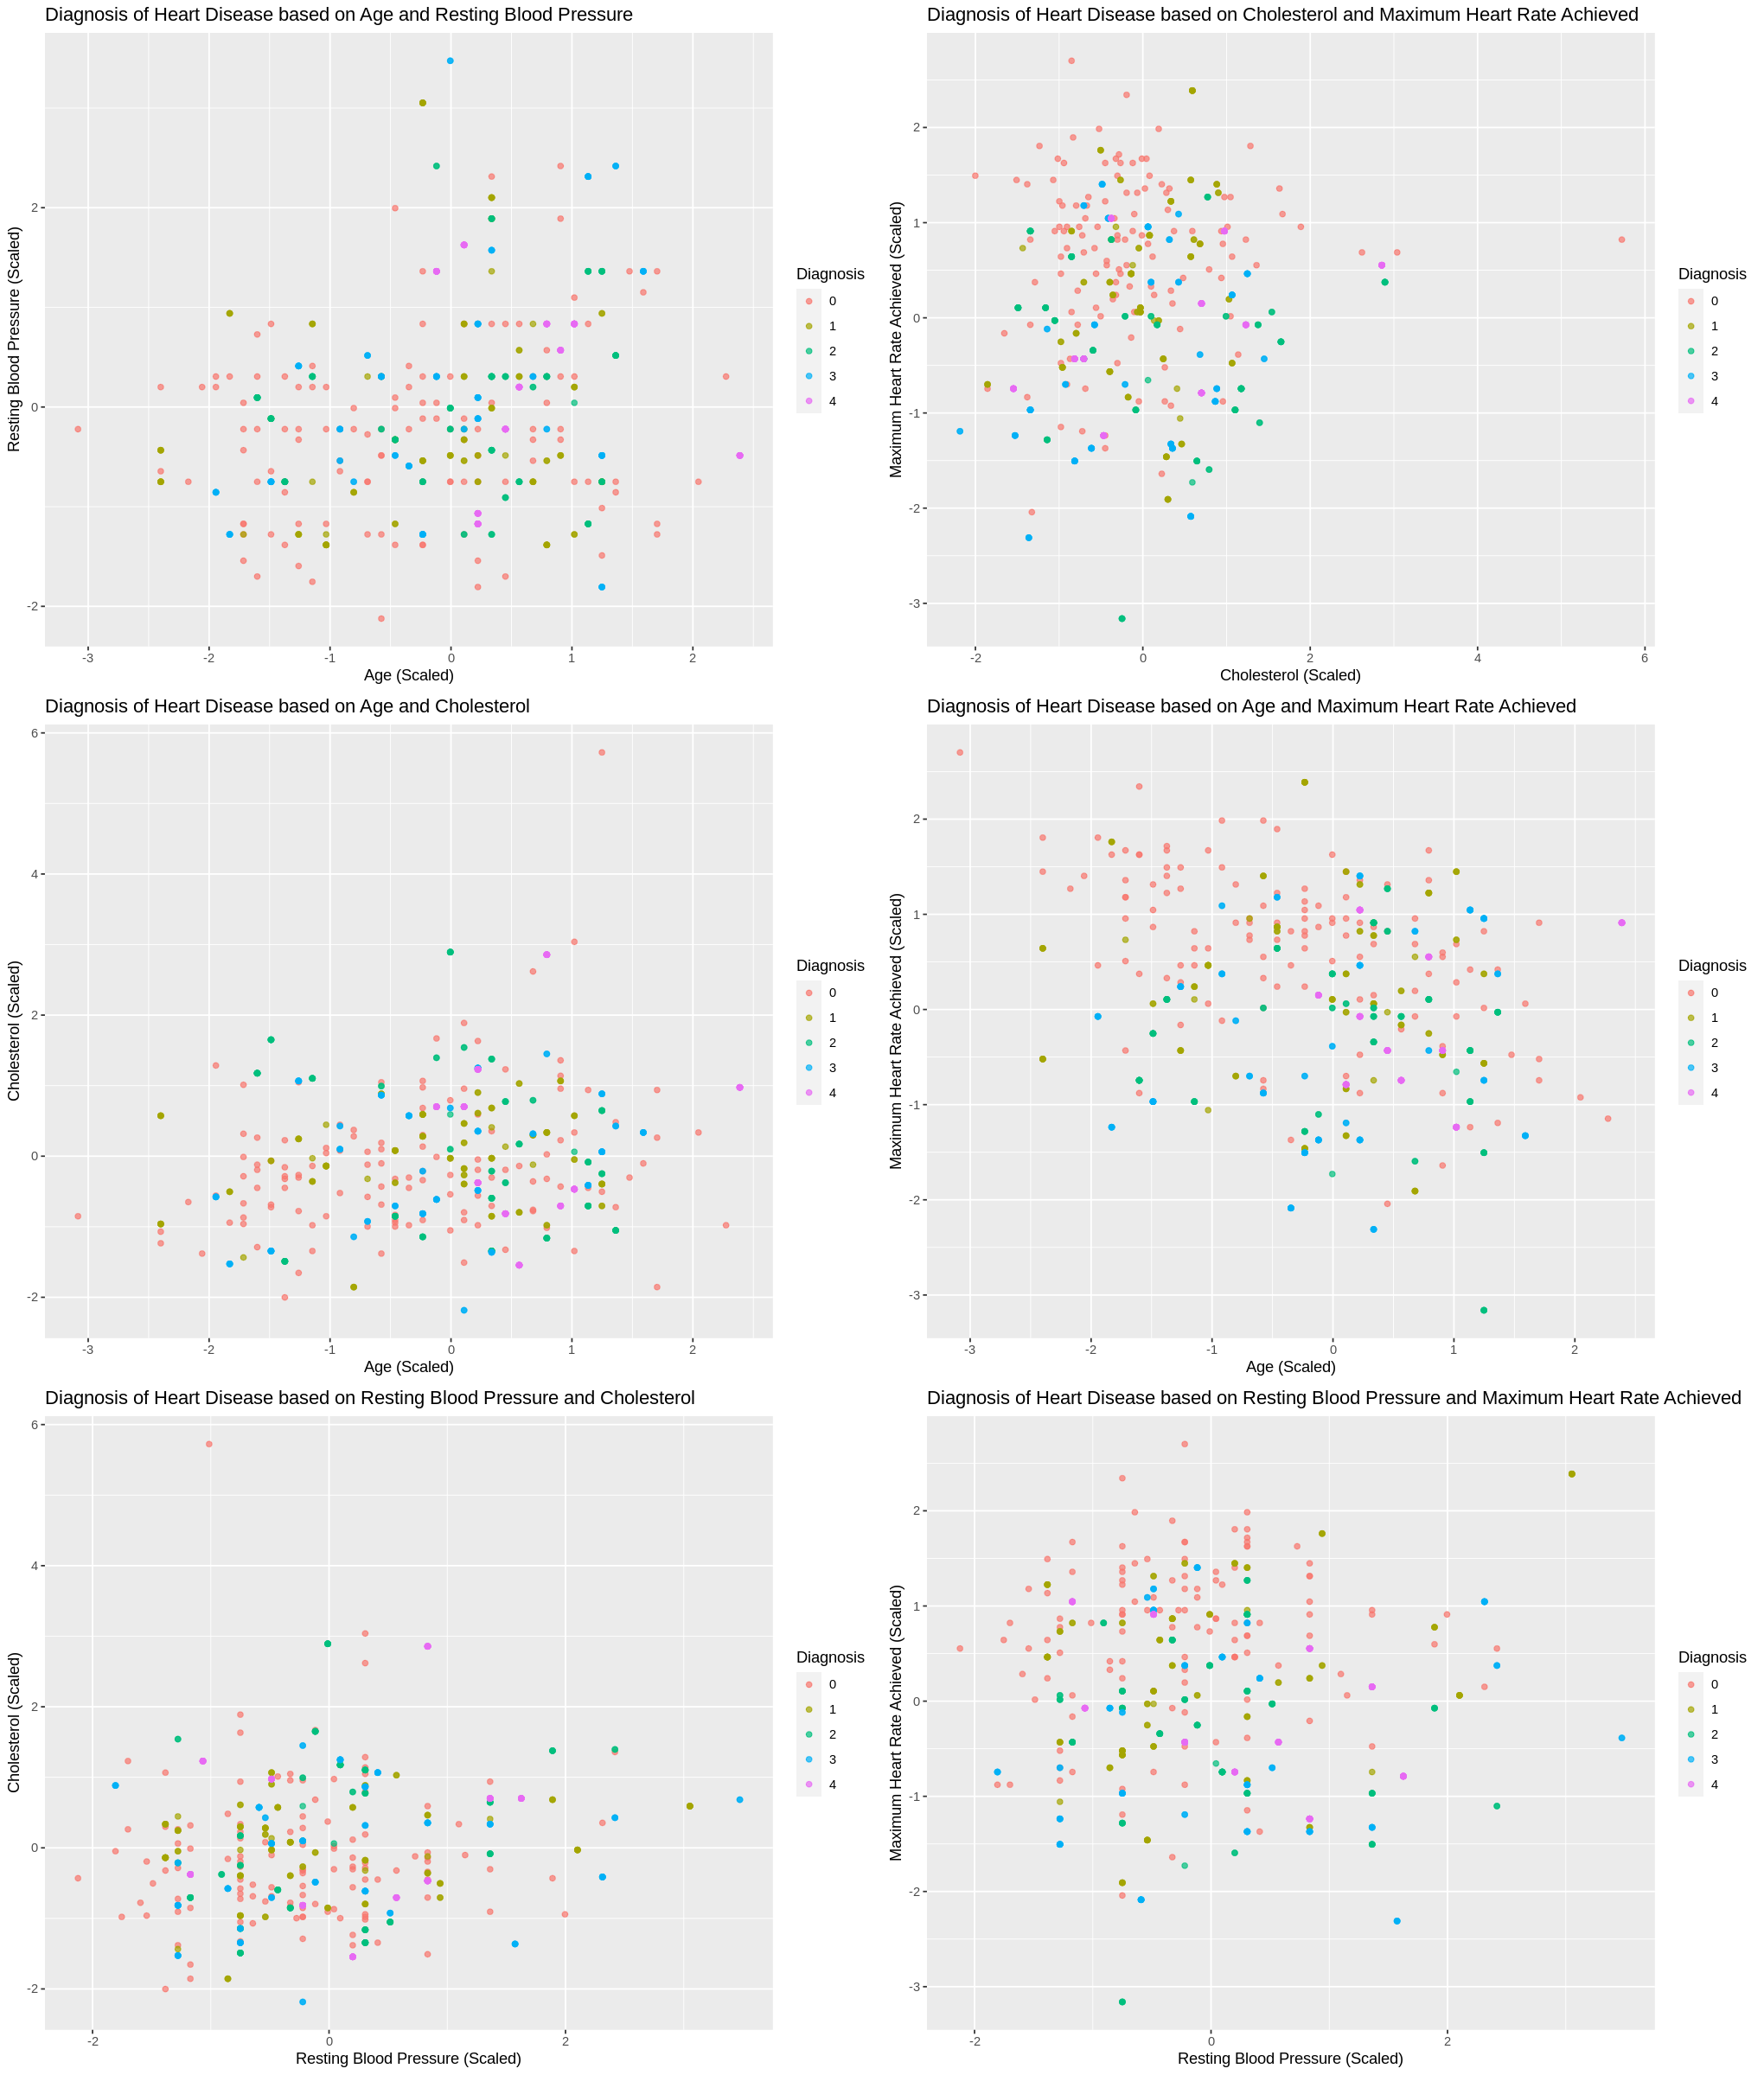

In [13]:
options(repr.plot.width = 17, repr.plot.height = 20)

cleveland_plot_1 <- training_scaled %>%
ggplot(aes(x=age, y=trestbps, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Resting Blood Pressure (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Resting Blood Pressure") 

cleveland_plot_2 <- training_scaled %>%
ggplot(aes(x=chol, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Cholesterol (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Cholesterol and Maximum Heart Rate Achieved")

cleveland_plot_3 <- training_scaled %>%
ggplot(aes(x=age, y=chol, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Cholesterol (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Cholesterol")

cleveland_plot_4 <- training_scaled %>%
ggplot(aes(x=age, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Maximum Heart Rate Achieved")

cleveland_plot_5 <- training_scaled %>%
ggplot(aes(x=trestbps, y=chol, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Resting Blood Pressure (Scaled)", y="Cholesterol (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Resting Blood Pressure and Cholesterol")

cleveland_plot_6 <- training_scaled %>%
ggplot(aes(x=trestbps, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Resting Blood Pressure (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Resting Blood Pressure and Maximum Heart Rate Achieved")

plot_grid(cleveland_plot_1, cleveland_plot_2, cleveland_plot_3, cleveland_plot_4, cleveland_plot_5, cleveland_plot_6, ncol = 2)


In [14]:
cleveland_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Up-sampling based on num
Scaling for all_predictors()
Centering for all_predictors()

In [15]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
                set_engine("kknn")%>%
                set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [21]:
cleveland_vfold <- vfold_cv(training_scaled, v = 5, strata = num)

In [34]:
set.seed(3546)

gridvals = tibble(neighbors = seq(from = 1, to = 10))

recipe_2 <- recipe(num~., data = training_scaled)

cleveland_results <- workflow() %>%
                    add_recipe(recipe_2) %>%
                    add_model(knn_tune) %>%
                    tune_grid(resamples = cleveland_vfold, grid = gridvals)%>%
                    collect_metrics() %>%
                    filter(.metric == "accuracy") 

cleveland_results

! Fold1: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3821852,5,0.01477947,Model01
2,accuracy,multiclass,0.3821852,5,0.01477947,Model02
3,accuracy,multiclass,0.4212396,5,0.01524243,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.4649275,5,0.02133141,Model08
9,accuracy,multiclass,0.4914010,5,0.01475949,Model09
10,accuracy,multiclass,0.4914935,5,0.01205654,Model10


In [35]:
best_k_val <- cleveland_results %>%
    arrange(mean)%>%
    slice(1)%>%
    pull(neighbors)
best_k_val

[1] 1